## Reducing dimensionality for topic models

This project was concerned with classifying deceptive from authentic reviews. This is a follow-up to the work been done so far and it specifically touches on how we can further improve the classifier's performance by applying a form of feature selection. To do this, I computed the mutual information for each bigram in the corpus and then removed bigrams which did not pass a certain threshold. 

The information threshold was set at 0.055 (13% of features removed).


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score,precision_score, make_scorer,fbeta_score
from sklearn import svm, tree
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, ShuffleSplit,train_test_split
from wordcloud import WordCloud
from collections import Counter
from itertools import combinations
from gensim import models,corpora,similarities
from nltk.util import ngrams
import string
import matplotlib.pyplot as plt
import re
import nltk

#import main dataset for training / testing

def import_data():
    
    reviews = pd.read_csv('deceptive-opinion.csv')
    reviews_txt =  reviews['text']
    
    labels = reviews['deceptive'].values
    labels = (labels == 'truthful') * 1
    labels = pd.Series(labels)
    
    truthful_indices = labels[labels == 1].index.values
    deceptive_indices = labels[labels == 0].index.values
                              
    return reviews_txt, labels, truthful_indices, deceptive_indices

def bigram_info(txt,inds1,inds2,freq,num_bins):
          
    num_docs = txt.shape[0]
      
    p_c1 = float(len(inds1)) / num_docs
    
    p_c2 = float(len(inds2)) / num_docs
    
    p_c = np.array([[p_c1],[p_c2]])
    
    type_entropy = -np.sum(p_c * np.log(p_c))
    
    ngram_counts = CountVectorizer(analyzer='word', ngram_range=(2, 2), min_df=1)
    bigram_counts = ngram_counts.fit_transform(txt)

    num_bigrams = len(ngram_counts.vocabulary_.values())

    bigram_vocab = [None] * num_bigrams

    for n in range(0,num_bigrams-1):
        
        index = ngram_counts.vocabulary_.values()[n]
        
        bigram_vocab[index] = ngram_counts.vocabulary_.keys()[n]
           
    
    subset_indices = (np.where(np.sum(bigram_counts.toarray(),axis=0)>freq))[0]
    
    bigram_vocab_subset = [bigram_vocab[i] for i in subset_indices]

    bigram_counts_subset = bigram_counts[:,subset_indices]
    
    num_bigrams_subset = np.shape(bigram_counts_subset)[1]
    
    info_gain = np.zeros(num_bigrams_subset)
    
    bins = range(0,num_bins)
    
    for n in range(0,num_bigrams_subset):
            
        p_wc = np.zeros((2,len(bins)-1))
        
        b, bin_edges = np.histogram(bigram_counts_subset[inds1,n].toarray(),bins=bins)
        
        p_wc[0,:] = b.astype('float') / len(inds1)
        
        b, bin_edges = np.histogram(bigram_counts_subset[inds2,n].toarray(),bins=bins)
        
        p_wc[1,:] = b.astype('float') / len(inds2)
        
        b, bin_edges = np.histogram(bigram_counts_subset[:,n].toarray(),bins=bins)
        
        p_w = b.astype('float') / num_docs
        
        p_cw = np.multiply(p_wc,p_c) / p_w     
        
        conditional_entropy = -np.nansum((p_w * p_cw) * np.log(p_cw))
        
        info_gain[n] = ((type_entropy - conditional_entropy) / type_entropy) * 100
        
        names = np.array(bigram_vocab_subset)    
        
        info_per_bigram = dict(zip(names,info_gain))
    
    return info_per_bigram


def remove_low_info(txt,low_info):
    
    num_docs = txt.shape[0]
    
    bigrams_docs = [None] * num_docs
        
    for i in range(0,num_docs):
        
        text=txt[i].lower().translate(None, string.punctuation)
        
        token = nltk.word_tokenize(text)
        
        bigrams = ngrams(token,2)
        
        valid_bigrams = [bigram for bigram in bigrams if ' '.join(bigram) not in low_info]
    
        bigrams_docs[i] = ['_'.join(valid_bigrams[n]) for n,item in enumerate(valid_bigrams)]
    
    return bigrams_docs

def train_classifier(clf,parameters,scorer,X,y):
        
    cv_sets = KFold(n_splits = 5, shuffle = True, random_state = 0)
    
    print "Parameter searching..."
    grid_obj = GridSearchCV(clf, parameters,cv=cv_sets,scoring=scorer)
    
    grid_fit = grid_obj.fit(X,y)
        
    best_clf = grid_fit.best_estimator_
      
    return best_clf,grid_fit
    

def test_classifier(best_clf,X_test,y_test):
 
    best_predictions = best_clf.predict(X_test)
    
    performance = {'accuracy': accuracy_score(best_predictions,y_test),
                   'recall': recall_score(best_predictions,y_test),
                   'precision': precision_score(best_predictions,y_test)
                   }
    
    return performance

def construct_corpus(docs):
    
        num_docs = len(docs)
    
        dictionary=corpora.Dictionary(docs)

        corpus = [dictionary.doc2bow(text) for text in docs]
        
        return corpus,dictionary

def extract_topic_dists(corpus,dictionary,num_topics,chunksize,passes):
    
    num_docs = np.shape(corpus)[0]
    
    model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics,alpha = 'auto',eta='auto',random_state=0, chunksize=chunksize, passes=passes)
    
    topic_dists = np.zeros([num_docs,num_topics])
    
    for i,item in enumerate(corpus):
        
        dists = model.get_document_topics(item)
        
        indices = dict(dists).keys()
        
        vals = dict(dists).values()
        
        topic_dists[i,indices] = vals
                   
    return topic_dists



C:\Users\andreas\Anaconda2\lib\site-packages\gensim-2.3.0-py2.7-win-amd64.egg\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Let's import the data

In [2]:
reviews_txt, labels, truthful_indices, deceptive_indices = import_data()

Now let's extract bigram mutual information with respect to category

In [3]:
info_per_bigram = bigram_info(reviews_txt,truthful_indices,deceptive_indices,0,50)

C:\Users\andreas\Anaconda2\lib\site-packages\ipykernel\__main__.py:88: RuntimeWarning: invalid value encountered in divide
C:\Users\andreas\Anaconda2\lib\site-packages\ipykernel\__main__.py:90: RuntimeWarning: divide by zero encountered in log
C:\Users\andreas\Anaconda2\lib\site-packages\ipykernel\__main__.py:90: RuntimeWarning: invalid value encountered in multiply


Rank found bigrams by info and set MI threshold at 0.05%. Any bigrams with lower values will be removed.

In [64]:
ranked_bigrams = np.array(info_per_bigram.keys())[np.argsort(info_per_bigram.values())]
ranked_vals = np.array(info_per_bigram.values())[np.argsort(info_per_bigram.values())]

low_info_bigrams = ranked_bigrams[:np.sum(ranked_vals < 0.055)]

print(len(low_info_bigrams)/float(len(info_per_bigram)))


0.130117994454


So we have the ranked bigrams, let's remove them from the reviews before any further processing

In [65]:
bigrams_docs = remove_low_info(reviews_txt,low_info_bigrams)

Form corpus and extract topic distributions for each review

In [66]:
corpus,dictionary = construct_corpus(bigrams_docs)
topic_dists = extract_topic_dists(corpus,dictionary,100,400,1)

Let's go through the classification process. 5-fold cross-validation with gridsearch of 2 (kernels) x 6 (C values) x 9 (gamma values) parameters.

In [67]:
clf_gridsearch = svm.SVC(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(topic_dists, labels, test_size = 0.2, random_state = 0)
scorer = make_scorer(fbeta_score,beta=0.5)

parameters_TM = {"kernel": ['rbf','linear'], "C": [0.1,0.2,0.4,0.6,0.8,1,10], "gamma": np.logspace(-1,1,9)}

best_clf_TM,grid_fit_TM = train_classifier(clf_gridsearch,parameters_TM,scorer,X_train,y_train)

performance_TM = test_classifier(best_clf_TM,X_test,y_test)

Parameter searching...


What are the classifier parameters?

In [68]:
print(grid_fit_TM.best_score_)
best_predictions = best_clf_TM.predict(X_test)
print(fbeta_score(best_predictions,y_test,0.5))

print(performance_TM)
print(best_clf_TM)

0.91167607961
0.892626131953
{'recall': 0.90196078431372551, 'precision': 0.89032258064516134, 'accuracy': 0.90000000000000002}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.56234132519,
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)


Form a distribution of accuracies to see where we stand.

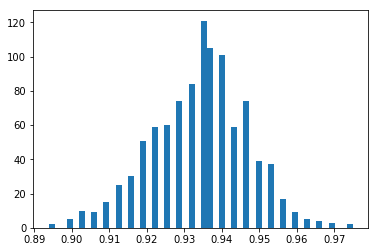


Mean accuracy: 0.93403749999999985
Standard deviation: 0.012697785239954251
Best accuracy value: 0.97499999999999998
Worst accuracy value: 0.89375000000000004


In [69]:
accuracy_dist = np.zeros(1000)
rand_init = np.zeros(1000)

for i in range(0,1000):
   rand_init[i] = np.floor(np.random.rand(1)[0]*10000)
   X_train, X_test, y_train, y_test = train_test_split(topic_dists, labels, test_size = 0.2, random_state = int(rand_init[i]))
   best_predictions = best_clf_TM.predict(X_test)
   accuracy_dist[i] = accuracy_score(best_predictions,y_test)

plt.hist(accuracy_dist,50)
plt.show()
s = "\nMean accuracy: " + repr(np.mean(accuracy_dist))
print(s)
s = "Standard deviation: " + repr(np.std(accuracy_dist))
print(s)
s = "Best accuracy value: " + repr(np.max(accuracy_dist))
print(s)
s = "Worst accuracy value: " + repr(np.min(accuracy_dist))
print(s)

Not bad. 

First of all, this * **outperforms** the 88% average accuracy of the benchmark model* (please see report.pdf). 

Secondly, this procedure basically highlights the importance of feature selection. The procedure which comes out of this is first to tokenize the review, remove the bigrams we've found which contain little to no information, and then extract topic distribution for the review (and simultaneously updating the topic model itself). Finally, we can classify the processed document.